In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [2]:

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [4]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [5]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
# load dataset
filename = 'dataset/dan-eng/dan.txt'
import pandas as pd
data = pd.read_csv(filename,sep='\t',header=None, names = ['english','danish','description'])
data.head()

,english,danish,description
0,Go.,Gå!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Hej!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Hej.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Løb!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run.,Løb!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [7]:
final = data.copy()

In [8]:
del final['description']

In [9]:
listdata = final.values.tolist()

In [54]:
dic = {
'french':'skrub af'   
}
df = pd.DataFrame(dic,columns=['french'])
df

ValueError: If using all scalar values, you must pass an index

In [50]:
dfdata = df.values.tolist()

In [52]:
dfdata

[['skrub af']]

In [53]:
listdata[1000:1010]

[["I'll clean up.", 'Jeg rydder op.'],
 ["I'll go first.", 'Jeg vil gå først.'],
 ["I'll help you.", 'Jeg vil hjælpe dig.'],
 ["I'll help you.", 'Jeg vil hjælpe jer.'],
 ["I'll make tea.", 'Jeg laver te.'],
 ["I'll prove it.", 'Jeg vil bevise det.'],
 ["I'll take him.", 'Jeg tager ham.'],
 ["I'm Tom's dad.", 'Jeg er Toms far.'],
 ["I'm Tom's mom.", 'Jeg er Toms mor.'],
 ["I'm a man now.", 'Jeg er en mand nu.']]

In [11]:
clean_pairs = clean_pairs(listdata)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-danish.pkl')
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-danish.pkl
[go] => [ga]
[hi] => [hej]
[hi] => [hej]
[run] => [lb]
[run] => [lb]
[wow] => [wow]
[fire] => [fyr]
[fire] => [ildebrand]
[help] => [hjlp]
[jump] => [hop]
[jump] => [spring]
[jump] => [hop]
[jump] => [spring]
[stop] => [stop]
[hello] => [hej]
[hello] => [hej]
[i see] => [jeg forstar]
[i won] => [jeg vandt]
[shoot] => [skyd]
[attack] => [angrib]
[cheers] => [skal]
[go now] => [ga nu]
[he ran] => [han lb]
[hop in] => [hop ind]
[i lied] => [jeg lj]
[i lied] => [jeg har ljet]
[i sang] => [jeg sang]
[no way] => [aldrig i livet]
[no way] => [ikke tale om]
[no way] => [absolut ikke]
[no way] => [under ingen omstndigheder]
[no way] => [aldrig i verden]
[no way] => [ikke pa vilkar]
[no way] => [du kan tro nej]
[no way] => [du kan bande pa nej]
[no way] => [niksen biksen]
[no way] => [nul putte]
[no way] => [det kan du glemme alt om]
[no way] => [pa ingen made]
[no way] => [det er ikke muligt]
[really] => [virkelig]
[really] => [er det rigtigt]
[really] => [ja sa]
[real

In [36]:
clean_pairs[:5,1]

array(['tom blev pakrt af en lastbil', 'tom lo ikke',
       'vi har ingen penge', 'jeg elsker at lse bger',
       'jeg hader interviews'], dtype='<U140')

In [12]:
raw_dataset = clean_pairs
 
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-danish-both.pkl')
save_clean_data(train, 'english-danish-train.pkl')
save_clean_data(test, 'english-danish-test.pkl')

Saved: english-danish-both.pkl
Saved: english-danish-train.pkl
Saved: english-danish-test.pkl


In [13]:
raw_dataset.shape

(21902, 2)

In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [15]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [16]:
from keras.preprocessing.text import Tokenizer

In [17]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('french Vocabulary Size: %d' % ger_vocab_size)
print('french Max Length: %d' % (ger_length))

English Vocabulary Size: 3286
English Max Length: 8
french Vocabulary Size: 4239
french Max Length: 11


In [18]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [21]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [22]:
trainX[10,:]

array([ 5,  6, 61, 15, 78,  0,  0,  0,  0,  0,  0], dtype=int32)

In [23]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [24]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# summarize defined model

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 256)           1085184   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 3286)           844502    
Total params: 2,980,310
Trainable params: 2,980,310
Non-trainable params: 0
_________________________________________________________________
None


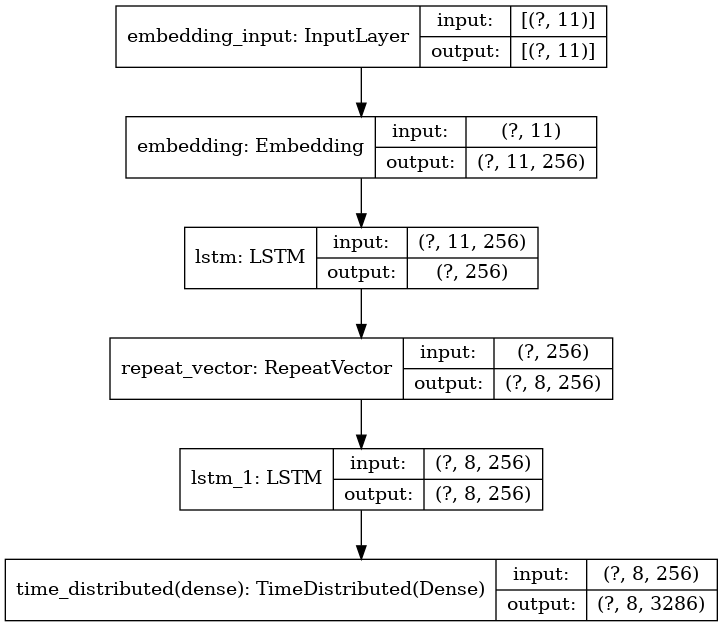

In [26]:
plot_model(model, to_file='danish_model.png', show_shapes=True)

In [27]:
filename = 'danish_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 3.31841, saving model to danish_model.h5
141/141 - 13s - loss: 4.0334 - val_loss: 3.3184
Epoch 2/50

Epoch 00002: val_loss improved from 3.31841 to 3.16859, saving model to danish_model.h5
141/141 - 13s - loss: 3.1660 - val_loss: 3.1686
Epoch 3/50

Epoch 00003: val_loss improved from 3.16859 to 3.11820, saving model to danish_model.h5
141/141 - 13s - loss: 3.0566 - val_loss: 3.1182
Epoch 4/50

Epoch 00004: val_loss improved from 3.11820 to 3.08934, saving model to danish_model.h5
141/141 - 13s - loss: 2.9794 - val_loss: 3.0893
Epoch 5/50

Epoch 00005: val_loss improved from 3.08934 to 3.03989, saving model to danish_model.h5
141/141 - 13s - loss: 2.9185 - val_loss: 3.0399
Epoch 6/50

Epoch 00006: val_loss improved from 3.03989 to 2.98260, saving model to danish_model.h5
141/141 - 13s - loss: 2.8371 - val_loss: 2.9826
Epoch 7/50

Epoch 00007: val_loss improved from 2.98260 to 2.91937, saving model to danish_model.h5
141/141 - 13s - 

In [28]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

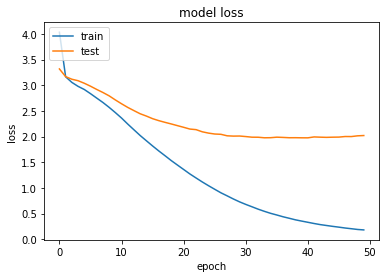

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [57]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))))
	print('BLEU-2: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))))
	print('BLEU-3: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))))
	print('BLEU-4: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))))

# load datasets
dataset = load_clean_sentences('english-danish-both.pkl')
train = load_clean_sentences('english-danish-train.pkl')
test = load_clean_sentences('english-danish-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[tom blev pakrt af en lastbil], target=[tom got hit by a truck], predicted=[tom had a much]
src=[tom lo ikke], target=[tom didnt laugh], predicted=[tom isnt woman]
src=[vi har ingen penge], target=[we have no money], predicted=[we have have the]
src=[jeg elsker at lse bger], target=[i love reading books], predicted=[i love made bet]
src=[jeg hader interviews], target=[i hate interviews], predicted=[i hope your]
src=[han kunne ikke lide at vre fattig], target=[he didnt like being poor], predicted=[he was let his did]
src=[tal aldrig med fremmede], target=[never talk to strangers], predicted=[the would nightingale the drinks]
src=[han fangede kyllingen], target=[he caught the chicken], predicted=[he illegal played sympathize]
src=[vask skeerne], target=[wash the spoons], predicted=[shy jail looking]
src=[jeg har ikke en tatovering], target=[i dont have a tattoo], predicted=[i dont have nothing the dogs]
BLEU-1: 31.85
BLEU-2: 18.72
BLEU-3: 14.30
BLEU-4: 6.62
test
src=[tom grined